# Thinkful Capstone: Modeling Churn

#### March 2017
#### by Amy Brown, amy.maria.brown@gmail.com, github.com/AmyinTX
#### Supervised by mentor Nemanja Radojković, nradojkovic@thinkful.com

### Project Summary

#### It is often less expensive for companies to retain current customers than it is to attract new customers.  Identifying customers who are at high risk of leaving a provider is key to minimizing customer attrition, or churn. 
#### This project utilizes supervised machine learning to predict churn, using one of the IBM sample datasets found here: https://www.ibm.com/communities/analytics/watson-analytics-blog/guide-to-sample-datasets/ . The WAFN UseC Telco Customer Churn dataset contains information on basic customer demographics and services acquired through a telecommunications provider, as well as their churn status (Yes/No). 
#### The analysis seeks to find the best machine learning classifier for predicting churn by comparing the performance of logistic regression, decision tree, and random forest classifiers, with metrics including accuracy, F1 score, and false negative rate. Ultimately, the best performing model is used to estimate the probability of customer churn and finds that the logistic classifier is the best option for doing so with this particular dataset. 
#### The following analysis and modeling proceeds in these steps:

#### Section 1. Load and explore data
#### Section 2. Clean and prepare data
#### Section 3. Define zero rate classifier (baseline)
#### Section 4. Define models and optimize hyperparameters
#### Section 5. Cross validate models
#### Section 6. Produce confusion matrices
#### Section 7. Evaluate classifier performance
#### Section 8. Identify strongest predictors of churn

### Section 1. Load and explore data

#### This section uploads the churn dataset and explores its attributes using a combination of visuals and the pandas package. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sb
from pandas.tools.plotting import scatter_matrix
from sklearn.metrics import f1_score as f1
% matplotlib inline

# Make graphs prettier
#pd.set_option('display.max_columns', 15)
#pd.set_option('display.width', 400)
#pd.set_option('display.mpl_style', 'default')

# Make the fonts bigger
plt.rc('figure', figsize=(14, 7))
plt.rc('font', family='normal', weight='bold', size=15)



/Users/amybrown/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
churn_data = pd.read_csv('/Users/amybrown/Thinkful/Capstone/Data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
churn_data.shape

(7043, 21)

#### The data have 7,043 observations and 21 variables. The table below, generated by churn_data.head() shows the first 5 observations for each of the 21 variables in the original data.

In [69]:
churn_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,...,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,...,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,...,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,...,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,...,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### The code below generates the data types for each of the variables. SeniorCitizen is an int but needs to be changed to object to be consistent with the other categorical variables in the dataset. 

In [70]:
churn_data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [71]:
churn_data['SeniorCitizen'] = churn_data['SeniorCitizen'].astype(str)

In [72]:
churn_data.dtypes

customerID           object
gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

#### The following provides summary statistics of the variables in the dataset. 

In [73]:
churn_data.describe(include='all')

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043,7043,7043,7043,7043.000000,7043,...,7043,7043,7043,7043,7043.000000,7043.000000,7043
unique,7043,2,2,2,2,NaN,2,...,3,3,2,4,NaN,NaN,2
top,8348-HFYIV,Male,0,No,No,NaN,Yes,...,No,Month-to-month,Yes,Electronic check,NaN,NaN,No
freq,1,3555,5901,3641,4933,NaN,6361,...,2785,3875,4171,2365,NaN,NaN,5174
mean,NaN,NaN,NaN,NaN,NaN,32.371149,NaN,...,NaN,NaN,NaN,NaN,64.761692,2277.717059,NaN
std,NaN,NaN,NaN,NaN,NaN,24.559481,NaN,...,NaN,NaN,NaN,NaN,30.090047,2266.795349,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,NaN,NaN,18.250000,18.800000,NaN
25%,NaN,NaN,NaN,NaN,NaN,9.000000,NaN,...,NaN,NaN,NaN,NaN,35.500000,395.225000,NaN
50%,NaN,NaN,NaN,NaN,NaN,29.000000,NaN,...,NaN,NaN,NaN,NaN,70.350000,1391.150000,NaN
75%,NaN,NaN,NaN,NaN,NaN,55.000000,NaN,...,NaN,NaN,NaN,NaN,89.850000,3780.625000,NaN


#### The histogram of churn status below shows a class imbalance, with those who churn representing 26.5% of the total observations in the dataset. This is an important point with respect to the evaluation of classifier performance. With unbalanced classes, the accuracy is not an ideal metric. This occurs because accuracy could just be reflective of the underlying distribution of the imbalanced data. Additionally, adjustments to this class imbalance can be made when tuning the hyperparameters to balance the classes in inverse proportion to their frequency, as seen in Section 4. In any event, this imbalance drives the selection of the performance metrics, discussed further in Section 7.

/Users/amybrown/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


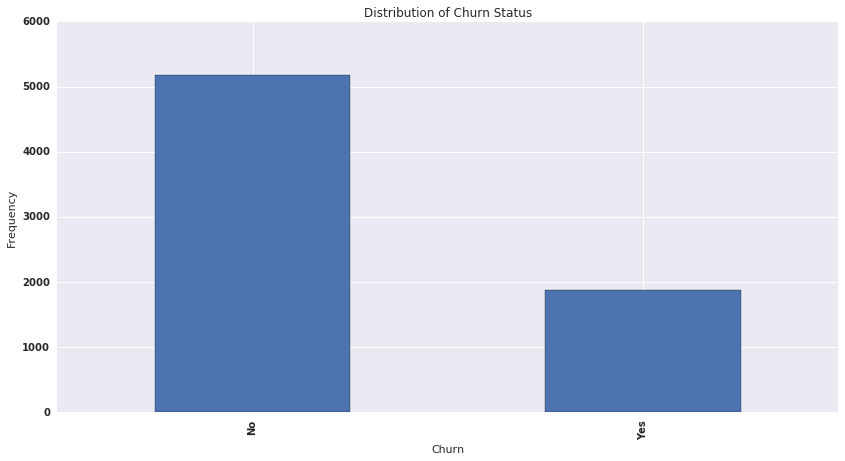

In [3]:
churn_data.Churn.value_counts().plot(kind='bar');
plt.xlabel('Churn');
plt.ylabel('Frequency');
plt.title('Distribution of Churn Status');

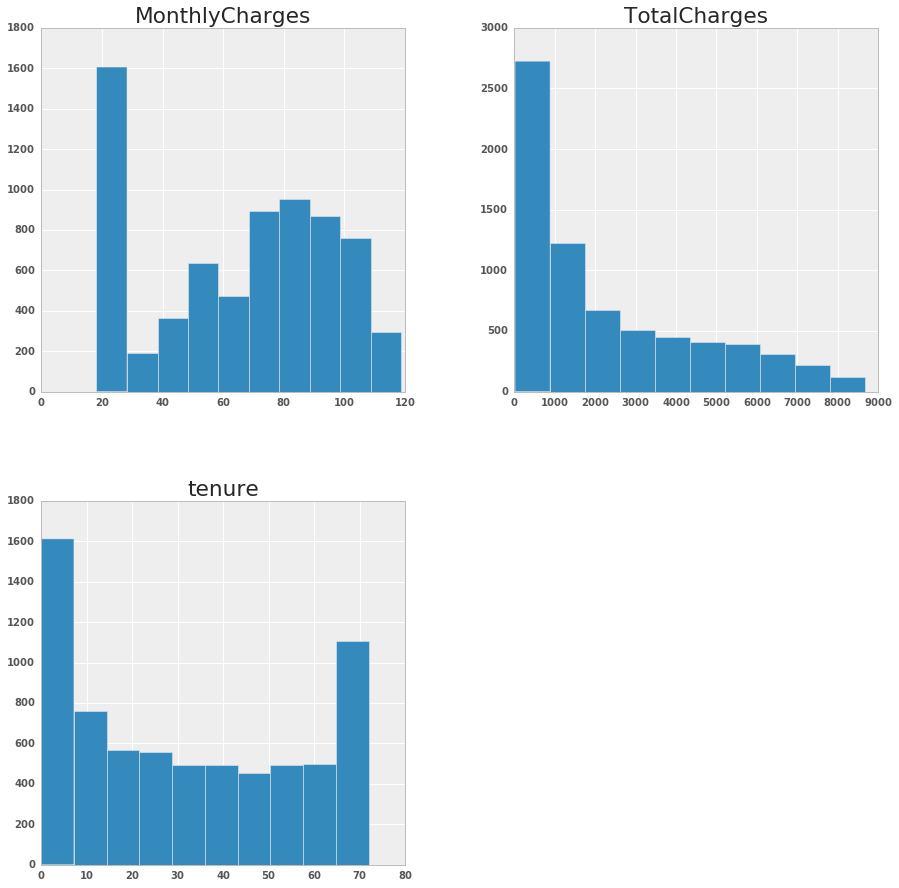

In [75]:
churn_data.hist(figsize=(15,15));
#plt.title('Distribution of Numeric Variables');

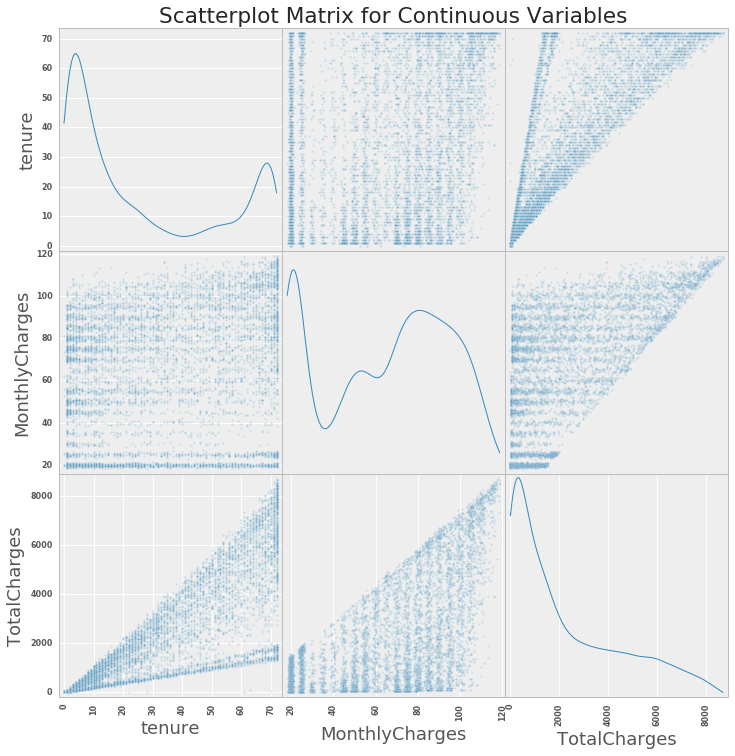

In [76]:
scatter_matrix(churn_data, alpha=0.2, figsize=(12, 12), diagonal='kde');
plt.title('Scatterplot Matrix for Continuous Variables',x=-.5, y=3);

### Section 2. Clean and prepare data

#### In this section we will make any necessary alterations to the dataset to prepare it for analysis. This includes making dummy variables for those features that are coded as 'Yes/No' and creating a variable that counts the number of additional products a customer enjoys besides basic internet and/or telephone service. Finally, we define the feature and target datasets. 

###### Create dummy variables:

In [77]:
df_sex = pd.get_dummies(churn_data['gender'])
df_partner = pd.get_dummies(churn_data['Partner'], prefix='Partner',prefix_sep=':')
df_depend = pd.get_dummies(churn_data['Dependents'], prefix='Dependent',prefix_sep=':')
df_phone = pd.get_dummies(churn_data['PhoneService'], prefix='Phone',prefix_sep=':')
df_lines = pd.get_dummies(churn_data['MultipleLines'], prefix='Multi-lines',prefix_sep=':')
df_internet = pd.get_dummies(churn_data['InternetService'], prefix='Internet', prefix_sep=':')
df_secure = pd.get_dummies(churn_data['OnlineSecurity'], prefix='Security', prefix_sep=':')
df_backup =  pd.get_dummies(churn_data['OnlineBackup'], prefix='Backup', prefix_sep=':')
df_protect = pd.get_dummies(churn_data['DeviceProtection'], prefix='Protection', prefix_sep=':')
df_support = pd.get_dummies(churn_data['TechSupport'], prefix='Support', prefix_sep=':')
df_streamtv = pd.get_dummies(churn_data['StreamingTV'], prefix='StreamTV', prefix_sep=':')
df_streammov = pd.get_dummies(churn_data['StreamingMovies'], prefix='StreamMov', prefix_sep=':')
df_contract = pd.get_dummies(churn_data['Contract'], prefix='Contract', prefix_sep=':')
df_billing = pd.get_dummies(churn_data['PaperlessBilling'], prefix='PaperlessBill', prefix_sep=':')
df_payment = pd.get_dummies(churn_data['PaymentMethod'], prefix='Method', prefix_sep=':')
df_churn = pd.get_dummies(churn_data['Churn'], prefix='Churn',prefix_sep=':')

###### Append dummy variables to the original dataset:

In [78]:
churn_dummies = pd.concat([churn_data, df_sex, df_partner, df_depend, df_phone, df_lines, df_internet,
                           df_secure, df_backup, df_protect, df_support, df_streamtv, df_streammov, df_contract,
                           df_billing, df_payment, df_churn], axis=1)

###### Create a variable that counts the additional services customers can choose from other than basic phone and internet:

In [79]:
churn_dummies['CountProducts'] = churn_dummies['Security:Yes'] + churn_dummies['Backup:Yes'] + churn_dummies['Protection:Yes'] + churn_dummies['Support:Yes'] + churn_dummies['StreamTV:Yes'] + churn_dummies['StreamMov:Yes'] 

###### Distribution of CountProducts variable:

In [80]:
churn_dummies['CountProducts'].value_counts()

0.0    2219
3.0    1118
2.0    1033
1.0     966
4.0     852
5.0     571
6.0     284
Name: CountProducts, dtype: int64

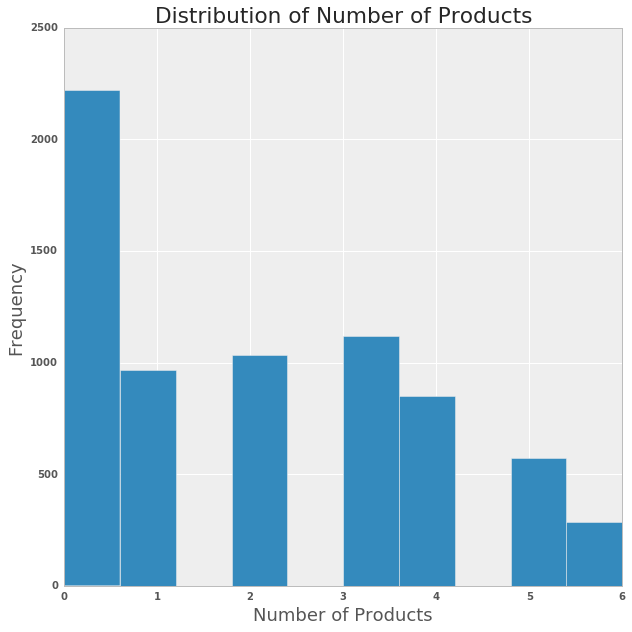

In [81]:
churn_dummies['CountProducts'].hist(figsize=(10,10));
plt.xlabel('Number of Products');
plt.ylabel('Frequency');
plt.title('Distribution of Number of Products');

###### Define outcome, where churn=Yes and assign to y:

In [82]:
churn_outcome = churn_dummies['Churn:Yes']
y = np.where(churn_outcome == 1, 1, 0)

###### Define feature space. Remember to leave out one of each of the dummy sets. Set feature space to X and scale:

In [83]:
churn_features = churn_dummies[['Female', 'Male', 'SeniorCitizen', 'Partner:No', 'Partner:Yes', 
                                'Dependent:No', 'Dependent:Yes', 'tenure',
                                'Phone:No', 'Phone:Yes', 'Multi-lines:Yes', 'Multi-lines:No',
                                'Multi-lines:No phone service', 'Internet:No',
                                'Internet:DSL', 'Internet:Fiber optic', 'CountProducts', 
                                'Contract:One year', 'Contract:Two year', 'Contract:Month-to-month',
                                'PaperlessBill:Yes', 'PaperlessBill:No', 'Method:Electronic check',
                                'Method:Mailed check', 'Method:Bank transfer (automatic)', 
                                'Method:Credit card (automatic)']]

X = churn_features
X = churn_features.as_matrix().astype(np.float)
scale = StandardScaler()
X = scale.fit_transform(X)

### Section 3. Define zero rate classifier (baseline)

#### In order to assess the performance of machine learning, we must have a baseline model for comparison. The zero rate classifier serves as that baseline. If we make the assumption that no customers will churn, we can then get a baseline measure of performance, which can be compared to the performance of the machine learning models to determine what gains are received by using machine learning. 

###### Define zero rate classifier, making the assumption that no one will churn:

In [84]:
zero_rate_true_y = y

no_churn_df = churn_dummies
no_churn_df['no_churn'] = 0.0
no_churn = no_churn_df['no_churn']
zero_rate_pred_y = no_churn_df['no_churn'].as_matrix()

###### Function that produces f1 score when fed the confusion matrix:

In [85]:
def f1(confusion_matrix):
    true_pos = confusion_matrix[1,1]
    false_pos = confusion_matrix[0,1]
    false_neg = confusion_matrix[1,0]
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    f1 = 2 * (precision*recall/precision + recall)
    print(f1)

In [86]:
zr_cm = confusion_matrix(zero_rate_true_y, zero_rate_pred_y)
print('Zero Rate Classifier Confusion Matrix:' + '\n' + str(zr_cm))

Zero Rate Classifier Confusion Matrix:
[[5174    0]
 [1869    0]]


In [87]:
# when you calculate this by hand, the f1 score is zero. I imagine it is returing nan because at some time you divide by zero.
f1(zr_cm)

nan


### Section 4. Define models and optimize hyperparameters

#### In this section, we define three machine learning models to apply to the problem of predicting churn. These classification models are logistic regression, decision tree, and random forest. 

#### Additionally, we want to be able to ensure we get the most out of these models by tuning the hyperparameters.  For instance, because of the class imbalance in the dataset, there is an hyperparameter for all three classifiers, class_weight, that can be used to artifically balance the classes. It does this by using "the values of y to automatically adjust weights inversely proportional to class frequences in the input data" (http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

###### Define models:

In [88]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF

classifiers = (LR,DT,RF)

#### To optimize the hyperparameters for each of the classifiers, we perform a gridsearch. This allows testing of the product of different parameters, such that if we wanted to tune three parameters, each with two different options, the grid search approach would evaluate a total of 6 different hyperparameter combinations.  In the block below, we specify the hyperparameters we would like to tune for each classifier and the different options to try. Especially important with respect to this dataset is the class_weight hyperparameter, which can help address the class imbalance. 

#### Additionally, we utilize two different metrics for identifying the best performing hyperparameter combinations, accuracy and the F1 score. Accuracy is the number of all correct predictions divided by the total number of observations; an accuracy of 1.0 would be the best. In the case of unbalanced classes, the accuracy is not particularly informative as it likely reflects the underlying distribution in the data. For example, if we made the assumption that no one will churn, due to the underlying class distribution, we would achieve an accuracy of 0.735 [5,174 correct churners / 7,043 total observations). A much better metric would be the F1-score, which takes into consideration both the precision (correct positives / total positives expected) and recall (true positives / all positives). For the purposes of this project, we will compare performance based on accuracy and the F1 score to demonstrate the dangers of using the accuracy as an evaluative metric. 

In [89]:
def optimization(classifier):
    """function that specifies and applies the hyperparameters for the grid search for each classifier and prints
       information on the best parameters and their performance """
    if classifier == LR:
        param_grid = {'class_weight': [None, 'balanced'], 
                      'solver': ['liblinear', 'sag', 'newton-cg', 'lbfgs']}
    if classifier == DT:
        param_grid = {'criterion': ['gini', 'entropy'], 
                      'splitter': ['best', 'random'], 
                      'class_weight': [None, 'balanced'],
                      'max_features': ['auto', 'sqrt', 'log2']}
    if classifier == RF:
        param_grid = {'n_estimators': range(1,20), 
                      'criterion': ['gini', 'entropy'], 
                      'max_features': ['auto', 'sqrt', 'log2'], 
                      'class_weight': [None, 'balanced']}
    print(str(classifier))
    print('Number of tested models: %i' % np.prod([len(param_grid[element]) for element in param_grid]))
    search = GridSearchCV(classifier(), param_grid, scoring='accuracy', cv=10)
    search.fit(X,y)
    print('Best parameters: %s' % search.best_params_)
    print('Best score: ' + str(search.best_score_))
        
for c in classifiers:
   optimization(c)

<class 'sklearn.linear_model.logistic.LogisticRegression'>
Number of tested models: 8
Best parameters: {'solver': 'sag', 'class_weight': None}
Best score: 0.801363055516
<class 'sklearn.tree.tree.DecisionTreeClassifier'>
Number of tested models: 24
Best parameters: {'max_features': 'log2', 'class_weight': None, 'criterion': 'gini', 'splitter': 'best'}
Best score: 0.744995030527
<class 'sklearn.ensemble.forest.RandomForestClassifier'>
Number of tested models: 228
Best parameters: {'max_features': 'sqrt', 'class_weight': None, 'criterion': 'entropy', 'n_estimators': 18}
Best score: 0.771688201051


#### In the block above, we use accuracy as a metric. All of the classifiers perform better than the zero rate classifier (0.735), with logistic regression performing the best. In the block below, we use the f1 score. Still, all models perform better than the zero rate classifier, again with logistic regression performing the best. Note that the hyperparameters that the grid search finds optimal changes with respect to the metric of choice. This is an important demonstration of how the selection of the best parameters is a function of the performance metric we choose, so we must choose carefully. 

In [90]:
def optimization(classifier):
    """function that specifies and applies the hyperparameters for the grid search for each classifier and prints
       information on the best parameters and their performance """
    if classifier == LR:
        param_grid = {'class_weight': [None, 'balanced'], 
                      'solver': ['liblinear', 'sag', 'newton-cg', 'lbfgs']}
    if classifier == DT:
        param_grid = {'criterion': ['gini', 'entropy'], 
                      'splitter': ['best', 'random'], 
                      'class_weight': [None, 'balanced'],
                      'max_features': ['auto', 'sqrt', 'log2']}
    if classifier == RF:
        param_grid = {'n_estimators': range(1,20), 
                      'criterion': ['gini', 'entropy'], 
                      'max_features': ['auto', 'sqrt', 'log2'], 
                      'class_weight': [None, 'balanced']}
    print(str(classifier))
    print('Number of tested models: %i' % np.prod([len(param_grid[element]) for element in param_grid]))
    search = GridSearchCV(classifier(), param_grid, scoring='f1', cv=10)
    search.fit(X,y)
    print('Best parameters: %s' % search.best_params_)
    print('Best score: ' + str(search.best_score_))
        
for c in classifiers:
    optimization(c)

<class 'sklearn.linear_model.logistic.LogisticRegression'>
Number of tested models: 8
Best parameters: {'solver': 'sag', 'class_weight': 'balanced'}
Best score: 0.618014331784
<class 'sklearn.tree.tree.DecisionTreeClassifier'>
Number of tested models: 24
Best parameters: {'max_features': 'log2', 'class_weight': 'balanced', 'criterion': 'gini', 'splitter': 'random'}
Best score: 0.527030275216
<class 'sklearn.ensemble.forest.RandomForestClassifier'>
Number of tested models: 228
Best parameters: {'max_features': 'log2', 'class_weight': 'balanced', 'criterion': 'entropy', 'n_estimators': 11}
Best score: 0.547585897658


### Section 5. Cross Validate Models

In [91]:
def run_cv(X,y,clf_class,**kwargs):
    kf = KFold(len(y),n_folds=5,shuffle=True, random_state=42)
    y_pred = y.copy()

    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train, y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

#### The average correct function compares the number of correctly predicted classes (whether positive or negative) and returns the average number of correctly identified classes. Note that for the zero rate classifier, the average correctly identified is equal to the accuracy. 

In [92]:
def avg_correct(y_true, y_pred):
    return np.mean(y_true == y_pred)

In [93]:
# these may change considering what i choose to use as best parameters...
# the f1 score I am assuming but I am holding off interpretation until then

print("Zero Rate:")
print("%.3f" % avg_correct(zero_rate_true_y, zero_rate_pred_y))

print('Logistic Regression:')
print("%.3f" % avg_correct(y, run_cv(X,y,LR,solver='sag', class_weight='balanced')))

print('Decision Tree:')
print("%.3f" % avg_correct(y, run_cv(X,y,DT,max_features='sqrt',splitter='random',criterion='entropy',class_weight='balanced')))

print('Random Forest:')
print("%.3f" % avg_correct(y, run_cv(X,y,RF,max_features='sqrt',n_estimators=7, criterion='entropy',class_weight='balanced')))

Zero Rate:
0.735
Logistic Regression:
0.740
Decision Tree:
0.726
Random Forest:
0.753


### Section 6. Produce confusion matrices

In [94]:
y = np.array(y)
class_names = np.unique(y)

In [95]:
zr_cm = confusion_matrix(zero_rate_true_y, zero_rate_pred_y)
print('Zero Rate Classifier Confusion Matrix:' + '\n' + str(zr_cm))

lr_cm = confusion_matrix(y,run_cv(X,y,LR))
print('Logistic Regression Classifier Confusion Matrix:' + '\n' + str(lr_cm))

dt_cm = confusion_matrix(y,run_cv(X,y,DT))
print('Decision Tree Classifier Confusion Matrix:' + '\n' + str(dt_cm))

rf_cm = confusion_matrix(y,run_cv(X,y,RF))
print('Random Forest Classifier Confusion Matrix:' + '\n' + str(rf_cm))

# I think I need to make a dictionary with the model as key and any sort of text to annotate blocks as values
# so I can just reference that and run this in a loop

# will interpret confusion matrices once hyperparameters and final models for each classifier are decided upon

Zero Rate Classifier Confusion Matrix:
[[5174    0]
 [1869    0]]
Logistic Regression Classifier Confusion Matrix:
[[4656  518]
 [ 870  999]]
Decision Tree Classifier Confusion Matrix:
[[4221  953]
 [ 976  893]]
Random Forest Classifier Confusion Matrix:
[[4538  636]
 [1004  865]]


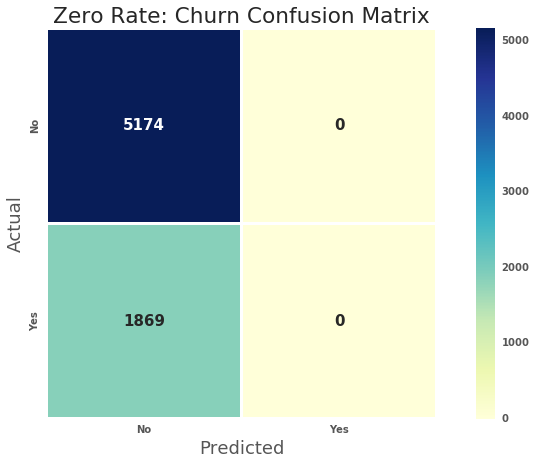

In [96]:
ax = sb.heatmap(zr_cm,annot=True, fmt='d', linewidths=2, cmap="YlGnBu", square=True, xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
ax.set_title('Zero Rate: Churn Confusion Matrix');
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');

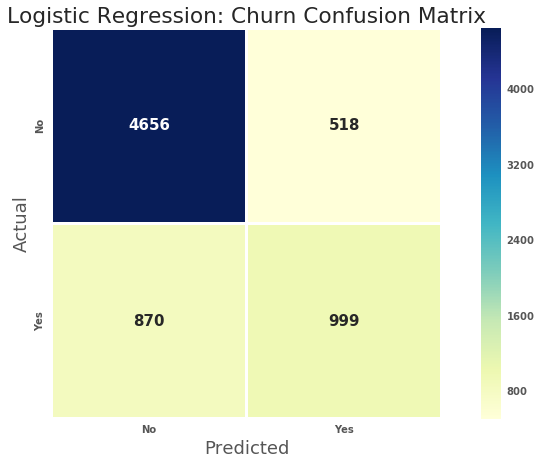

In [97]:
ax = sb.heatmap(lr_cm,annot=True, fmt='d', linewidths=2, cmap="YlGnBu", square=True, xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
ax.set_title('Logistic Regression: Churn Confusion Matrix');
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');

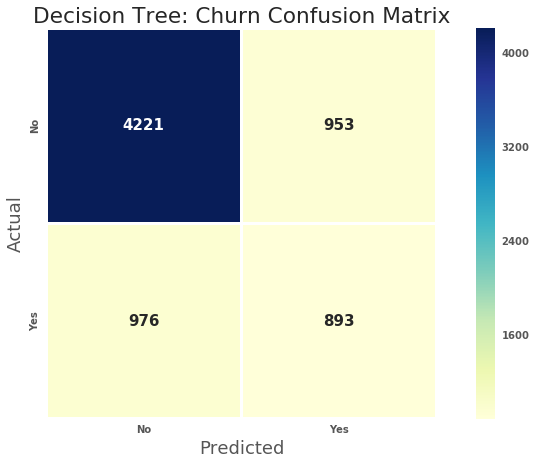

In [98]:
ax = sb.heatmap(dt_cm,annot=True, fmt='d', linewidths=2, cmap="YlGnBu", square=True, xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
ax.set_title('Decision Tree: Churn Confusion Matrix');
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');

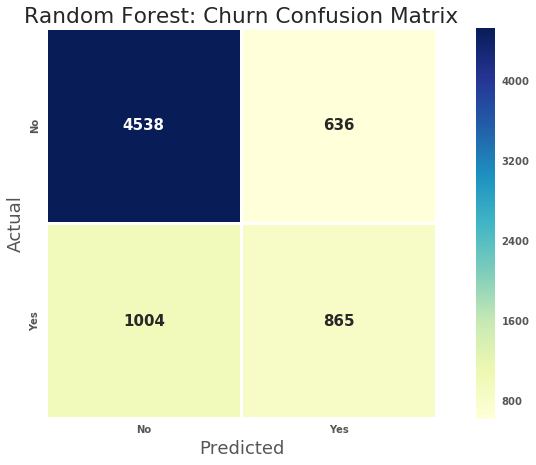

In [99]:
ax = sb.heatmap(rf_cm,annot=True, fmt='d', linewidths=2, cmap="YlGnBu", square=True, xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
ax.set_title('Random Forest: Churn Confusion Matrix');
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');

### Section 7. Evaluate classifier performance

In [100]:
def false_neg(confusion_matrix):
    false_negs = confusion_matrix[1,0]
    true_pos = confusion_matrix[1,1]
    denom = false_negs + true_pos
    false_negative_rate = false_negs/denom
    print(false_negative_rate)

In [101]:
def f1(confusion_matrix):
    true_pos = confusion_matrix[1,1]
    false_pos = confusion_matrix[0,1]
    false_neg = confusion_matrix[1,0]
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    f1 = 2 * (precision*recall/precision + recall)
    print(f1)

In [102]:
cm_list = zr_cm, lr_cm, dt_cm, rf_cm

for cm in cm_list:
    false_neg(cm) # want to minimize false negatives

1.0
0.465489566613
0.522204387373
0.537185660781


In [103]:
for cm in cm_list:
    f1(cm)

nan
2.13804173355
1.91118245051
1.85125735688


In [104]:
final = run_cv(X,y,LR,solver='sag', class_weight='balanced')

In [105]:
def final_cv(X,y,clf_class,**kwargs):
    kf = KFold(len(y),n_folds=5,shuffle=True, random_state=42)
    y_pred = y.copy()

    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train, y_train)
        y_pred[test_index] = clf.predict(X_test)
        pps = clf.predict_proba(X_test)
        c = clf.coef_
    return c

In [106]:
lr_coeffs = final_cv(X,y,LR,solver='sag', class_weight='balanced')
print(lr_coeffs)
type(lr_coeffs)
lr_coeffs_flat = [val for sublist in lr_coeffs.tolist() for val in sublist]
lr_coeffs_flat

[[-0.0113702   0.0113702   0.10030829  0.01401872 -0.01401872  0.03002473
  -0.03002473 -0.78546806  0.04033091 -0.04033091  0.07004527 -0.09310326
   0.04033091 -0.35556536 -0.12500959  0.41475547  0.0028637  -0.02445298
  -0.3538923   0.32409566  0.07652578 -0.07652578  0.16208094 -0.05759912
  -0.05846025 -0.0684216 ]]


[-0.011370195376434087,
 0.011370195376434087,
 0.10030828719076891,
 0.014018724244978032,
 -0.014018724245015768,
 0.03002472546217028,
 -0.030024725462185323,
 -0.785468059836249,
 0.04033090872781528,
 -0.040330908727867945,
 0.07004527157604117,
 -0.09310326169435167,
 0.04033090872781528,
 -0.35556535841123527,
 -0.1250095930764581,
 0.4147554684963229,
 0.002863696958643626,
 -0.024452975836957064,
 -0.35389230472095956,
 0.32409566382711985,
 0.07652577878893634,
 -0.07652577878887129,
 0.1620809350565093,
 -0.057599120569092936,
 -0.05846024797438859,
 -0.06842160060047918]

In [107]:
feature_list = list(churn_features.columns.values)
print(feature_list)
type(feature_list)

['Female', 'Male', 'SeniorCitizen', 'Partner:No', 'Partner:Yes', 'Dependent:No', 'Dependent:Yes', 'tenure', 'Phone:No', 'Phone:Yes', 'Multi-lines:Yes', 'Multi-lines:No', 'Multi-lines:No phone service', 'Internet:No', 'Internet:DSL', 'Internet:Fiber optic', 'CountProducts', 'Contract:One year', 'Contract:Two year', 'Contract:Month-to-month', 'PaperlessBill:Yes', 'PaperlessBill:No', 'Method:Electronic check', 'Method:Mailed check', 'Method:Bank transfer (automatic)', 'Method:Credit card (automatic)']


list

In [108]:
feature_coeffs = dict(zip(feature_list, lr_coeffs_flat))
feature_coeffs

{'Contract:Month-to-month': 0.32409566382711985,
 'Contract:One year': -0.024452975836957064,
 'Contract:Two year': -0.35389230472095956,
 'CountProducts': 0.002863696958643626,
 'Dependent:No': 0.03002472546217028,
 'Dependent:Yes': -0.030024725462185323,
 'Female': -0.011370195376434087,
 'Internet:DSL': -0.1250095930764581,
 'Internet:Fiber optic': 0.4147554684963229,
 'Internet:No': -0.35556535841123527,
 'Male': 0.011370195376434087,
 'Method:Bank transfer (automatic)': -0.05846024797438859,
 'Method:Credit card (automatic)': -0.06842160060047918,
 'Method:Electronic check': 0.1620809350565093,
 'Method:Mailed check': -0.057599120569092936,
 'Multi-lines:No': -0.09310326169435167,
 'Multi-lines:No phone service': 0.04033090872781528,
 'Multi-lines:Yes': 0.07004527157604117,
 'PaperlessBill:No': -0.07652577878887129,
 'PaperlessBill:Yes': 0.07652577878893634,
 'Partner:No': 0.014018724244978032,
 'Partner:Yes': -0.014018724245015768,
 'Phone:No': 0.04033090872781528,
 'Phone:Yes': 

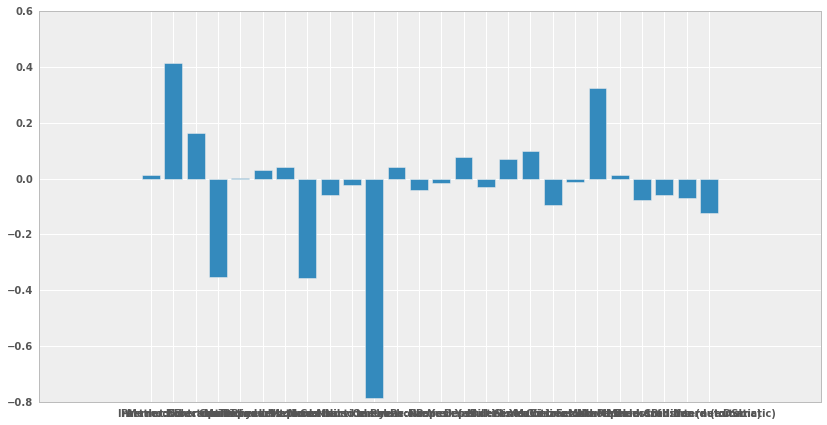

In [109]:
plt.bar(range(len(feature_coeffs)), feature_coeffs.values(), align='center')
plt.xticks(range(len(feature_coeffs)), feature_coeffs.keys());
plt.figure(figsize=(30,30));